# Général

### Bibliothèques importées

In [3]:
import numpy as np
import random as rd
from datetime import datetime
from time import strftime
import uuid as uuid
import matplotlib.pyplot as plt
from matplotlib import animation

### Variables globales

##### Variables générales

In [4]:
#type(n) : int
#n est la taille de la matrice carrée
n = 100

#type(nb_renards_initial) : int
#nb_renards_initial le nombre initial de renards
nb_renards_initial = 500

#type(nb_lapins_initial) : int
#nb_lapins_initital le nombre initial de lapins
nb_lapins_initial = 1500

#type(M) : int
#M le range de l'entourage de Moore
M = 1

##### Variables relatives aux carottes

In [5]:
#type(probabilite_presence_carotte) : float [0.00 ; 1.00]
#probabilite_presence_carotte est la probabilité qu'il n'y ait pas de carottes sur une case
probabilite_presence_carotte = 0.5

gain_densite_carotte = 0.1

##### Variables relatives aux lapins

In [6]:
#type(esperance_vie_lapin) : int
#esperance_vie_lapin est un nb de jours
esperance_vie_lapin = 2555 #environ 7 ans

#type(efficacite_lapin) : float
#efficacite_lapin est un pondérateur fictif pour éviter un système mathématique trop prédominant, c'est le facteur chance naturel
def efficacite_lapin_specifique():
    return rd.uniform(-0.1,0.1)

#type(maturite_sexuelle_lapin) : int
#maturite_sexuelle_lapin le nb de jours pour pouvoir s'accoupler
maturite_sexuelle_lapin = 310 #donnée réelle, correspond à 10 mois

#type(temps_gestation_lapin) : int
#temps_gestation_lapin le nb de jours avant de mettre bas
temps_gestation_lapin = 55 #donnée réelle

#type(seuil_lapin) : int
#seuil_lapin le pourcentage au dessus duquel le lapin cherchera de la nourriture ou à se reproduire
seuil_lapin = 0.8

gain_excitation_lapin = 0.01
gain_faim_lapin = 0.01

##### Variables relatives aux renards

In [7]:
#type(esperance_vie_renard) : int
#esperance_vie_renard est un nb de jours
esperance_vie_renard = 1825 #environ 5 ans

#type(efficacite_renard) : float
#efficacite_renard est l'efficacité de chasse du renard, i.e. sa chance d'attraper le lapin
efficacite_renard_generale = 0.20 #basé sur des données réelles
def efficacite_renard_specifique():
    return rd.uniform(-0.1,0.1)

#type(maturite_sexuelle_renard) : int
#maturite_sexuelle_renard le nb de jours pour pouvoir s'accoupler
maturite_sexuelle_renard = 310 #donnée réelle, correspond à 10 mois

#type(temps_gestation_renard) : int
#temps_gestation_renard le nb de jours avant de mettre bas
temps_gestation_renard = 55 #donnée réelle

#type(seuil_renard) : int
#seuil_renard le pourcentage au dessus duquel le lapin cherchera de la nourriture ou à se reproduire
seuil_renard = 0.8

gain_excitation_renard = 0.01
gain_faim_renard = 0.01

# Agents

### Renard

In [8]:
def creation_renard(age, position):
    ID = uuid.uuid4()
    sexe = rd.choice([True, False]) #True correspond à femelle
    efficacite = efficacite_renard_generale + efficacite_renard_specifique()
    fecondite = rd.uniform(0.2,1.0)
    faim = rd.random()
    excitation = rd.random()
    gestationnaire = (False, 0, 0) #en gestation ou non, nb de jour avant mis à bas, nb de renardeaux
    type_agent = "renard"
    
    return (ID, (type_agent, (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position)))

In [9]:
def creation_renards():
    cpt = 0 #type(cpt) : int
    renards = dict()
    while cpt < nb_renards_initial:
        cpt += 1
        identifiant, renard = creation_renard(rd.randint(0,esperance_vie_renard),(rd.randint(0,n-1),rd.randint(0,n-1)))        
        renards[identifiant] = renard
    #print cpt
    return renards

### Lapin

In [10]:
def creation_lapin(age, position):
    """None -> lapin
    lapin : tuple[int, bool, float, float, float, float, tuple[bool, int], tuple[int, int]]"""
    ID = uuid.uuid4()
    sexe = rd.choice([True, False]) #True correspond à femelle
    efficacite = efficacite_lapin_specifique()
    fecondite = rd.uniform(0.2,1.0)
    faim = rd.random()
    excitation = rd.random()
    gestationnaire = (False, 0, 0) #en gestation ou non, nb de jour avant mis à bas, nb de lapinous
    type_agent = "lapin"
    
    return (ID, (type_agent, (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position)))

In [11]:
def creation_lapins():
    cpt = 0 #type(cpt) : int
    lapins = dict()
    while cpt < nb_lapins_initial:
        cpt += 1
        identifiant, lapin = creation_lapin(rd.randint(0, esperance_vie_lapin),(rd.randint(0,n-1),rd.randint(0,n-1)))        
        lapins[identifiant] = lapin
    return lapins

### Carotte

In [12]:
def creation_carotte(ligne, colonne):
    return (uuid.uuid4(), ("carotte", (rd.random(),(ligne, colonne))))

In [13]:
def creation_carottes():
    cpt = 0
    carottes = dict()
    while cpt < n*n - 1:
        cpt += 1
        if rd.random() >= probabilite_presence_carotte:
            identifiant, carotte = creation_carotte((cpt-(cpt%n))//n,cpt%n)
            carottes[identifiant] = carotte
    return carottes

### Mélange des agents

On déclare en variable globale le dictionnaire rassemblant tous nos agents

In [14]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

# Environnement

### Initialisation de l'environnement

In [15]:
def init_matrice():
    a = np.empty((n,n), dtype = np.object_)
    a.fill([])
    a = np.frompyfunc(list,1,1)(a)
    return a

### Placement des agents dans l'environnement

In [16]:
def update_matrice():
    for e in agents:
        type_agent,agent = agents[e]
        if type_agent == "lapin":
            _,_,_,_,_,_,_,position = agent
            ligne, colonne = position
            environnement[ligne, colonne].append(e)
        elif type_agent == "renard":
            _,_,_,_,_,_,_,position = agent
            ligne, colonne = position
            environnement[ligne, colonne].append(e)
        elif type_agent == "carotte":
            _,position = agent
            ligne, colonne = position 
            environnement[ligne, colonne].append(e)
    return environnement

# Tour


### Fonctions de déplacement

##### Renards

In [17]:
def reussite_chasse(efficacite_renard,efficacite_lapin):
    """donne un booléen qui correspond à l'issue de la chasse du renard"""
    return rd.random() < (efficacite_renard-efficacite_lapin)

In [18]:
def nb_renardeaux(age1,age2,fec1,fec2):
    """donne le nombre de renardeaux dans une portée aléatoirement"""
    #d : int
    d = 0
    if age1 > maturite_sexuelle_renard and age2 > maturite_sexuelle_renard:
        if (fec1 + fec2) / 2 >= 0.5:
            d = rd.choice([4,5])
    return d

In [31]:
def mouvement_renard(id_renard):
    
    _, renard = agents[id_renard]
    age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position = renard
    ligne, colonne = position
    en_gestation, jour, nb = gestationnaire
    
    #On met à jour ses variables
    age += 1 #il prend un jour de plus
    if age > esperance_vie_renard:
        environnement[ligne, colonne].remove(id_renard)
        return
    #le sexe ne change pas
    #l'efficacite ne change pasu
    #la fecondite ne change pas
    excitation += gain_excitation_renard
    faim += gain_faim_renard
    if faim > 1:
        environnement[ligne, colonne].remove(id_renard)
        return
    #on s'occupe du tuple gestationnaire
    if en_gestation:
        jour += 1
        if jour == temps_gestation_renard:
            cpt_renardeaux = 0
            while cpt_renardeaux < nb:
                cpt_renardeaux += 1
                id_enfant, enfant = creation_renard(1,(ligne, colonne))
                agents[id_enfant] = enfant
                environnement[ligne, colonne].append(id_enfant)
            print "%s renardeaux sont nés" % nb
            en_gestation = False
            jour = 0
            nb = 0
            gestationnaire = (en_gestation, jour, nb)
    #La position ne change pas
    
    entourage_moore = [] #liste des uuid aux environs
    
    for a in range((ligne-M),(ligne+M)+1):
        for b in range((colonne-M),(colonne+M)+1):
            for c in environnement[a%n,b%n]:
                if c != id_renard:
                    entourage_moore.append(c)
    
    #On retire les carottes de l'entourage
    entourage_moore_renard = []
    entourage_moore_lapin = []
    
    for e in entourage_moore:
        type_agent,_ = agents[e]
        if type_agent == "renard":
            entourage_moore_renard.append(e)
        elif type_agent == "lapin":
            entourage_moore_lapin.append(e)        
    
    #On examine si le renard veut manger ou se reproduire
    if ((faim >= excitation and len(entourage_moore_lapin) != 0) or (faim < excitation and len(entourage_moore_lapin) != 0 and len(entourage_moore_renard)==0)) and faim > seuil_renard:
        
        id_proie = rd.choice(entourage_moore_lapin)
        _,proie = agents[id_proie]
        age_proie, sexe_proie, efficacite_proie, fecondite_proie, excitation_proie, faim_proie, gestationnaire_proie, position_proie = proie
        ligne_proie, colonne_proie = position_proie
        
        if reussite_chasse(efficacite, efficacite_proie):
            if id_proie in environnement[ligne_proie, colonne_proie]:
                environnement[ligne_proie, colonne_proie].remove(id_proie)
            faim = 0
        #On repack le tuple du renard
        position = (ligne_proie, colonne_proie)
        agents[id_renard] = ("renard", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))
        environnement[ligne, colonne].remove(id_renard)
        environnement[ligne_proie, colonne_proie].append(id_renard)
        
    elif ((faim < excitation and len(entourage_moore_renard) != 0) or (faim >= excitation and len(entourage_moore_lapin) == 0 and len(entourage_moore_renard) !=0)) and excitation > seuil_renard:
        
        id_proie = rd.choice(entourage_moore_renard)
        _,proie = agents[id_proie]
        age_proie, sexe_proie, efficacite_proie, fecondite_proie, excitation_proie, faim_proie, gestationnaire_proie, position_proie = proie
        en_gestation_proie, jour_proie, nb_proie = gestationnaire_proie
        ligne_proie, colonne_proie = position_proie
        
        #Les deux sexes doivent être différents.
        #Aucun des deux ne doit être en gestation, et le male n'est jamais en gestation.
        if sexe_proie != sexe and en_gestation == en_gestation_proie:
            excitation = 0
            excitation_proie = 0
            if sexe:
                nb = nb_renardeaux(age, age_proie, fecondite, fecondite_proie)
                jour = temps_gestation_renard
                en_gestation = True
                gestationnaire = (en_gestation, jour, nb)
                position = (ligne_proie, colonne_proie)
            else:
                nb_proie = nb_renardeaux(age, age_proie, fecondite, fecondite_proie)
                jour_proie = temps_gestation_renard
                en_gestation_proie = True
                gestationnaire_proie = (en_gestation_proie, jour_proie, nb_proie)
                position = (ligne_proie, colonne_proie)
            agents[id_renard] = ("renard", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))
            agents[id_proie] = ("renard", (age_proie, sexe_proie, efficacite_proie, fecondite_proie, excitation_proie, faim_proie, gestationnaire_proie, position_proie))
        environnement[ligne, colonne].remove(id_renard)
        environnement[ligne_proie, colonne_proie].append(id_renard)
    else:
        #Mouvement aléatoire
        environnement[ligne, colonne].remove(id_renard)
        ligne = (ligne + rd.choice(range(-M,M+1)))%n
        colonne = (colonne + rd.choice(range(-M,M+1)))%n
        environnement[ligne, colonne].append(id_renard)
        position = (ligne, colonne)
        agents[id_renard] = ("renard", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))

##### Lapins

In [20]:
def nb_lapinous(age1,age2,fec1,fec2):
    """donne le nombre de lapinous dans une portée en fonction des fécondités des parents"""
    #k:int
    k=0
    if age1>124 and age2>124:
        if (fec1+fec2)/2>=0.2:
            k=4+int(((fec1+fec2)/2-0.2)*10)
    return k

In [30]:
def mouvement_lapin(id_lapin):
    
    _, lapin = agents[id_lapin]
    age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position = lapin
    ligne, colonne = position
    en_gestation, jour, nb = gestationnaire
    
    #On met à jour ses variables
    age += 1 #il prend un jour de plus
    if age > esperance_vie_lapin:
        environnement[ligne, colonne].remove(id_lapin)
        return
    #le sexe ne change pas
    #l'efficacite ne change pas
    #la fecondite ne change pas
    excitation += gain_excitation_lapin
    faim += gain_faim_lapin
    if faim > 1:
        environnement[ligne, colonne].remove(id_lapin)
        return
    #on s'occupe du tuple gestationnaire
    if en_gestation:
        jour += 1
        if jour == temps_gestation_lapin:
            cpt_lapinous = 0
            while cpt_lapinous < nb:
                cpt_lapinous += 1
                id_enfant, enfant = creation_lapin(1,(ligne, colonne))
                agents[id_enfant] = enfant
                environnement[ligne, colonne].append(id_enfant)
            print "%s lapinous sont nés" % nb
            en_gestation = False
            jour = 0
            nb = 0
            gestationnaire = (en_gestation, jour, nb)
    #La position ne change pas 
    
    entourage_moore = [] #liste des uuid aux environs
    
    for a in range((ligne-M),(ligne+M)+1):
        for b in range((colonne-M),(colonne+M)+1):
            for c in environnement[a%n,b%n]:
                if id_lapin != c:
                    entourage_moore.append(c)
    
    #On retire les renards de l'entourage
    #Cela implique qu'il n'y a pas d'interactions renard-lapin venant du lapin. Pas de fuite (?)
    entourage_moore_carotte = []
    entourage_moore_lapin = []
    
    for e in entourage_moore:
        type_agent,_ = agents[e]
        if type_agent == "carotte":
            entourage_moore_carotte.append(e)
        if type_agent == "lapin":
            entourage_moore_lapin.append(e)
    
    #On examine si le lapin veut manger ou se reproduire
    if ((faim >= excitation and len(entourage_moore_carotte) != 0) or (faim < excitation and len(entourage_moore_lapin) == 0 and len(entourage_moore_carotte)!=0)) and faim > seuil_lapin:
        
        #Cas de la prédation
        
        id_proie = rd.choice(entourage_moore_carotte)
        _, proie = agents[id_proie]
        nb_proie, position_proie = proie
        ligne_proie, colonne_proie = position_proie
        
        if nb_proie >= .1:
            nb_proie -= 0.1
            faim = 0
        #On repack le tuple du lapin et de la carotte
        position = (ligne_proie, colonne_proie)
        agents[id_lapin] = ("lapin", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))
        agents[id_proie] = (["carotte"], (nb_proie, position_proie))
        environnement[ligne, colonne].remove(id_lapin)
        environnement[ligne_proie, colonne_proie].append(id_lapin)
        
    elif ((faim < excitation and len(entourage_moore_lapin) != 0) or (faim >= excitation and len(entourage_moore_carotte) == 0 and len(entourage_moore_lapin) !=0)) and excitation > seuil_lapin:
        
        #Cas de la reproduction
        
        id_proie = rd.choice(entourage_moore_lapin)
        _,proie = agents[id_proie]
        age_proie, sexe_proie, efficacite_proie, fecondite_proie, excitation_proie, faim_proie, gestationnaire_proie, position_proie = proie
        en_gestation_proie, jour_proie, nb_proie = gestationnaire_proie
        ligne_proie, colonne_proie = position_proie
        
        #Les deux sexes doivent être différents.
        #Aucun des deux ne doit être en gestation, et le male n'est jamais en gestation.
        if sexe_proie != sexe and en_gestation == en_gestation_proie:
            excitation = 0
            excitation_proie = 0
            if sexe:
                nb = nb_lapinous(age, age_proie, fecondite, fecondite_proie)
                jour = temps_gestation_lapin
                en_gestation = True
                gestationnaire = (en_gestation, jour, nb)
                position = (ligne_proie, colonne_proie)
            else:
                nb_proie = nb_lapinous(age, age_proie, fecondite, fecondite_proie)
                jour_proie = temps_gestation_lapin
                en_gestation_proie = True
                gestationnaire_proie = (en_gestation_proie, jour_proie, nb_proie)
                position = (ligne_proie, colonne_proie)
            agents[id_lapin] = ("lapin", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))
            agents[id_proie] = ("lapin", (age_proie, sexe_proie, efficacite_proie, fecondite_proie, excitation_proie, faim_proie, gestationnaire_proie, position_proie))
        environnement[ligne, colonne].remove(id_lapin)
        environnement[ligne_proie, colonne_proie].append(id_lapin)
    else:
        #Mouvement aléatoire
        #print(environnement[ligne, colonne])
        environnement[ligne, colonne].remove(id_lapin)
        ligne = (ligne + rd.choice(range(-M,M+1)))%n
        colonne = (colonne + rd.choice(range(-M,M+1)))%n
        environnement[ligne, colonne].append(id_lapin)
        position = (ligne, colonne)
        agents[id_lapin] = ("lapin", (age, sexe, efficacite, fecondite, excitation, faim, gestationnaire, position))

##### Carottes

In [22]:
def mouvement_carotte(id_carotte):
    _, carotte = agents[id_carotte]
    densite, position = carotte
    densite += gain_densite_carotte
    (densite,position) = carotte
    agents[id_carotte] = ("carotte", carotte)

### Fonction de tour

In [23]:
def tour():
    for a in agents:
        type_agent, agent = agents[a]
        if type_agent == "lapin":
            _, _, _, _, _, _, _, position = agent
            ligne, colonne = position
            if a in environnement[ligne, colonne]:
                mouvement_lapin(a)
            
        elif type_agent == "renard":
            _, _, _, _, _, _, _, position = agent
            ligne, colonne = position
            if a in environnement[ligne, colonne]:
                mouvement_renard(a)
        
        else:
            _, position = agent
            ligne, colonne = position
            if a in environnement[ligne, colonne]:
                mouvement_carotte(a)
    
    matrice_renard, matrice_lapin, matrice_carotte = casse_matrice()
    results_renard.append(matrice_renard)
    results_lapin.append(matrice_lapin)
    results_carotte.append(matrice_carotte)
    
    return environnement

In [24]:
def tours(nb_jour):
    #Exécute n fois la fonction tour, avec n un nombre de jours
    cpt = 0
    while cpt < nb_jour:
        cpt += 1
        tour()
    return environnement

# Exécution complète

In [25]:
results_renard = []
results_lapin = []
results_carotte = []

def execution_complete(nb_jour):
    
    global results_renard
    global results_lapin
    global results_carotte
    global environnement
    global agents

    #On init l'environnement
    environnement = init_matrice()
    #On init le dico des agents
    agents = merge_two_dicts(creation_carottes(),merge_two_dicts(creation_lapins(), creation_renards()))
    #On update la matrice avec les uuid du dico
    update_matrice()
    #On exécute n tours
    tours(nb_jour)
    return (results_renard, results_lapin, results_carotte)

In [26]:
def casse_matrice():

    matrice_renard = np.zeros((n,n))
    matrice_lapin = np.zeros((n,n))
    matrice_carotte = np.zeros((n,n))

    cpt_ligne = 0
    cpt_colonne = 0
    cpt_renard = 0
    cpt_lapin = 0
    densite = 0

    for a in environnement:
        for b in a:
            for c in b:
                type_agent,agent = agents[c]
                if type_agent == "lapin":
                    cpt_lapin += 1
                if type_agent == "renard":
                    cpt_renard += 1
                if type_agent == "carotte":
                    densite,_ = agent
                matrice_carotte[cpt_ligne, cpt_colonne] = densite
                densite = 0
            matrice_renard[cpt_ligne, cpt_colonne] = cpt_renard
            matrice_lapin[cpt_ligne, cpt_colonne] = cpt_lapin            
            cpt_lapin = 0
            cpt_renard = 0
            cpt_colonne += 1
        cpt_ligne += 1
        cpt_colonne = 0
    return (matrice_renard, matrice_lapin, matrice_carotte)

In [27]:
%matplotlib notebook

2018-05-01 10:47:46.976000


<IPython.core.display.Javascript object>


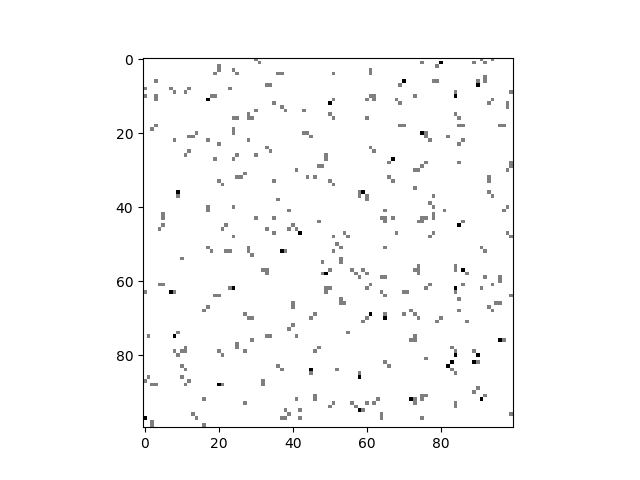

<IPython.core.display.Javascript object>


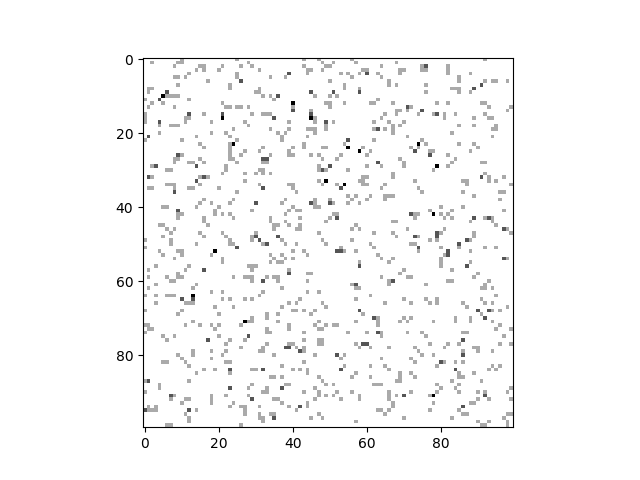

2018-05-01 10:49:10.576000


In [32]:
print(str(datetime.now()))
results_renard = []
results_lapin = []
results_carotte = []

nb_jour = 1000

execution_complete(nb_jour)

fig = plt.figure()
im = plt.imshow(results_renard[0], animated=True, cmap = plt.cm.gray_r)
def updatefig(i):
    im.set_array(results_renard[i+1])
    return im
ani = animation.FuncAnimation(fig, updatefig, frames=nb_jour-1, interval=200, blit=True)
mywriter = animation.FFMpegWriter()
ani.save('basic_animation_test.mp4',writer=mywriter)
plt.show()

fig2 = plt.figure()
im2 = plt.imshow(results_lapin[0], animated=True, cmap = plt.cm.gray_r)
def updatefig2(i):
    im2.set_array(results_lapin[i+1])
    return im2
ani2 = animation.FuncAnimation(fig2, updatefig2, frames=nb_jour-1, interval=200, blit=True)
mywriter = animation.FFMpegWriter()
ani2.save('basic_animation_test2.mp4',writer=mywriter)
plt.show()

#print(results_renard)
print(str(datetime.now()))